# Cancer Diagonostics

## Goal
Using [set of breast cancer data](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29), create a model to predict breast cancer. Also, determine traits that are most indicative of whether or not an individual will be diagnosed.

In [37]:
# setting environment
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [38]:
cancer_raw = pd.read_csv('data/breast-cancer-wisconsin.data', header=None)

In [39]:
cancer_raw.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [40]:
# change the column names
name = ['id', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion',
       'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal Nucleoli', 'Mitoses',
       'Class']
cancer_raw.columns = name

In [41]:
cancer_raw.head()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [42]:
# check if there is any missing value
cancer_raw.isnull().sum()

id                             0
Clump_Thickness                0
Uniformity_of_Cell_Size        0
Uniformity_of_Cell_Shape       0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [43]:
# check the data info
cancer_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                             699 non-null int64
Clump_Thickness                699 non-null int64
Uniformity_of_Cell_Size        699 non-null int64
Uniformity_of_Cell_Shape       699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    699 non-null object
Bland_Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [44]:
# examine Bare_Nuclei column since it is the only column that has string data type
cancer_raw['Bare_Nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [45]:
# impute the missing data 
from sklearn.impute import SimpleImputer
impute = SimpleImputer(missing_values='?', strategy='most_frequent')
cancer_raw['Bare_Nuclei'] = impute.fit_transform(cancer_raw[['Bare_Nuclei']]).astype('int')

In [46]:
# check the imputing result
cancer_raw['Bare_Nuclei'].value_counts()

1     418
10    132
5      30
2      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

Since we are predicting whether the patient got cancer or not, we will transform target variable of original data to 0(benign) and 1(malignant)

In [47]:
cancer_raw['Class'] = cancer_raw['Class'].map({2:0, 4:1})

In [48]:
# check the composition between non-cancer and cancer patients
cancer_raw['Class'].value_counts()

0    458
1    241
Name: Class, dtype: int64

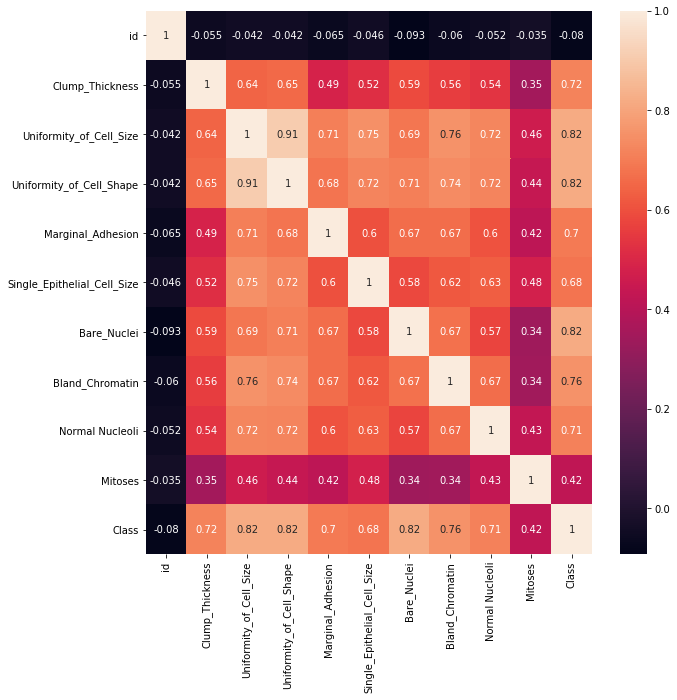

In [49]:
# plot the correlation heatmap
fig = plt.figure(figsize=(10,10))
sns.heatmap(cancer_raw.corr(), annot=True)
plt.show()

Looks like id column has pretty much no use for our prediction, we will drop it

In [50]:
cancer_raw.drop('id', axis=1, inplace=True)

In [51]:
# examine the correlation again
cancer_raw.corr()['Class'].sort_values(ascending=False)

Class                          1.000000
Bare_Nuclei                    0.818968
Uniformity_of_Cell_Shape       0.818934
Uniformity_of_Cell_Size        0.817904
Bland_Chromatin                0.756616
Clump_Thickness                0.716001
Normal Nucleoli                0.712244
Marginal_Adhesion              0.696800
Single_Epithelial_Cell_Size    0.682785
Mitoses                        0.423170
Name: Class, dtype: float64

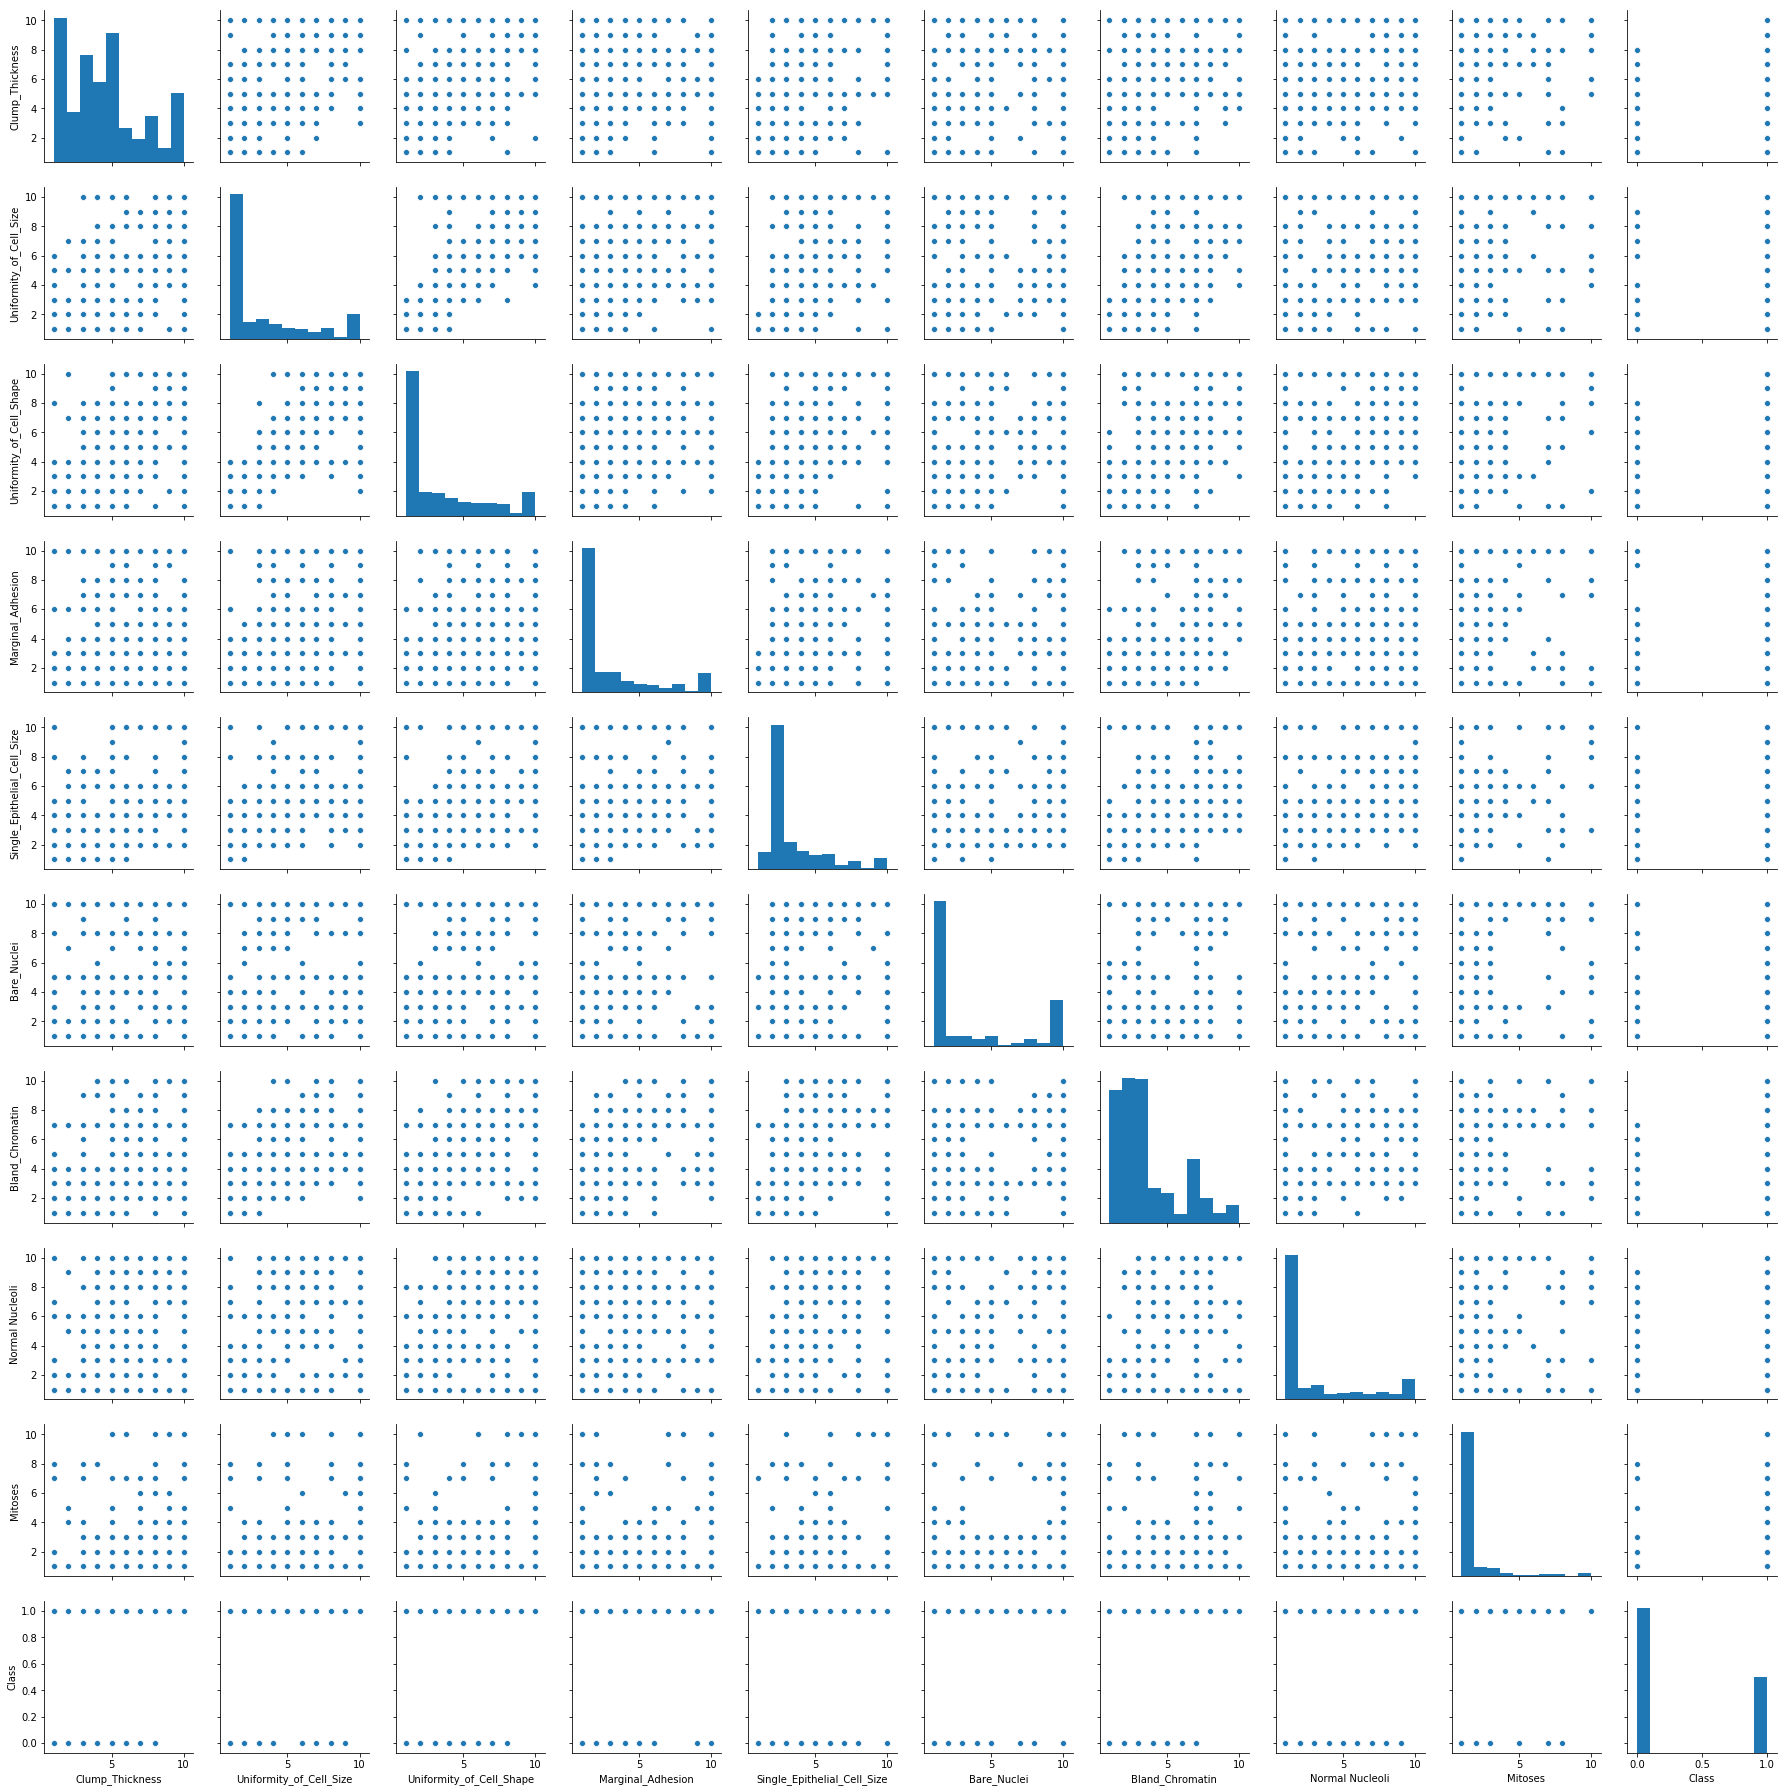

In [52]:
sns.pairplot(cancer_raw)

We will split our data into traing and testing sets

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cancer_raw.drop('Class', axis=1), cancer_raw['Class'],
                                                   test_size=0.3, stratify=cancer_raw['Class'])

In [54]:
# define a function that performs gridsearch to tune hyperparameters
from sklearn.model_selection import GridSearchCV
def get_best_model_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0., cv=5) 
    grid.fit(X, y)
    # our classical metric for performance
    print("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))
    return grid.best_params_

In [55]:
# define a function that print out the precision, recall, f1 score as well as plotting the ROC curve using the 
# best parameters of that model
def roc_curve_plot(model, params, X, y):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(cancer_raw.drop('Class', axis=1), cancer_raw['Class'],
                                                test_size=0.3, stratify=cancer_raw['Class'], random_state=1009)
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    print('Precision: {}'.format(precision_score(y_test, model.predict(X_test))))
    print('Recall: {}'.format(recall_score(y_test, model.predict(X_test))))
    print('F1 score: {}'.format(f1_score(y_test, model.predict(X_test))))
    
    try:
        y_scores = cross_val_predict(model, X, y, method='decision_function', cv=5)
    except AttributeError: 
        y_scores = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
                                         
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis=([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    print('Area under the curve: {}'.format(roc_auc_score(y, y_scores)))
    

We will start the model fitting

In [56]:
# base score to beat
y_train.value_counts(normalize=True)

0    0.654397
1    0.345603
Name: Class, dtype: float64

The base accuracy score to beat is 0.654

### Naive bayes

Best Accuracy: 0.9059304703476483
Best Parameters: {'alpha': 0, 'fit_prior': True}
Average Time to Fit (s): 0.004
Average Time to Score (s): 0.001
Precision: 0.8709677419354839
Recall: 0.75
F1 score: 0.8059701492537312


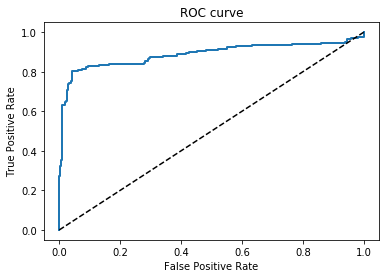

Area under the curve: 0.8880732248520709


In [57]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive_params = {'alpha': [0,0.5,1],
                'fit_prior': [True, False]}
best = get_best_model_accuracy(naive, naive_params, X_train, y_train)
# use the best parameters to fit the model
roc_curve_plot(naive, best, X_train, y_train)

### Logistic regression

Best Accuracy: 0.9693251533742331
Best Parameters: {'C': 1, 'penalty': 'l2'}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.001
Precision: 0.9701492537313433
Recall: 0.9027777777777778
F1 score: 0.9352517985611511


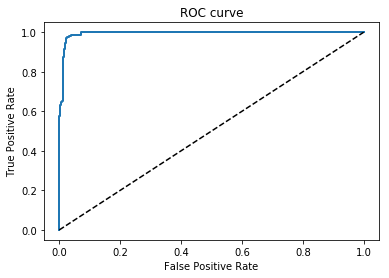

Area under the curve: 0.9937499999999999


In [58]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr_params = {'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1, 10]}
best = get_best_model_accuracy(lgr, lgr_params, X_train, y_train)
roc_curve_plot(lgr, best, X_train, y_train)

### Decision tree

Best Accuracy: 0.9488752556237219
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.002
Average Time to Score (s): 0.001
Precision: 0.9054054054054054
Recall: 0.9305555555555556
F1 score: 0.9178082191780821


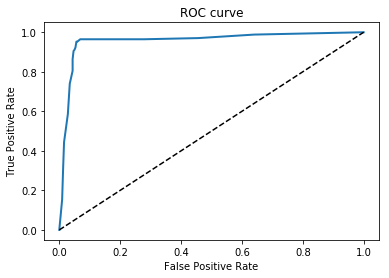

Area under the curve: 0.9558709319526628


In [59]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree_params = {'max_depth': [1,3,5,7,9]}
best = get_best_model_accuracy(tree, tree_params, X_train, y_train)
roc_curve_plot(tree, best, X_train, y_train)

### Random forest

Best Accuracy: 0.967280163599182
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.011
Average Time to Score (s): 0.002
Precision: 0.9444444444444444
Recall: 0.9444444444444444
F1 score: 0.9444444444444444


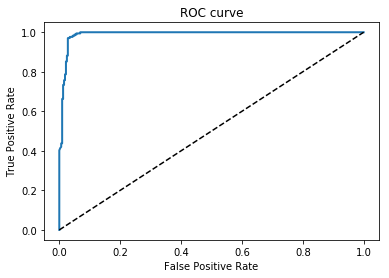

Area under the curve: 0.9897651627218934


In [60]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_params = {'max_depth': [1,3,5,7,9]}
best = get_best_model_accuracy(rf, rf_params, X_train, y_train)
roc_curve_plot(rf, best, X_train, y_train)

### Linear support vector machine

Best Accuracy: 0.9693251533742331
Best Parameters: {'C': 1, 'penalty': 'l2'}
Average Time to Fit (s): 0.004
Average Time to Score (s): 0.0
Precision: 0.9714285714285714
Recall: 0.9444444444444444
F1 score: 0.9577464788732395


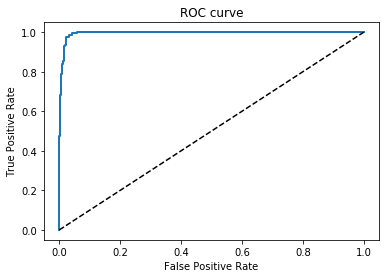

Area under the curve: 0.9948594674556213


In [61]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc_params = {'C': [0.01, 0.1, 1, 10, 100],
               'penalty': ['l1', 'l2']}
best = get_best_model_accuracy(lsvc, lsvc_params, X_train, y_train)
roc_curve_plot(lsvc, best, X_train, y_train)

### Support vector machine

Best Accuracy: 0.967280163599182
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Average Time to Fit (s): 0.006
Average Time to Score (s): 0.001
Precision: 0.8860759493670886
Recall: 0.9722222222222222
F1 score: 0.9271523178807947


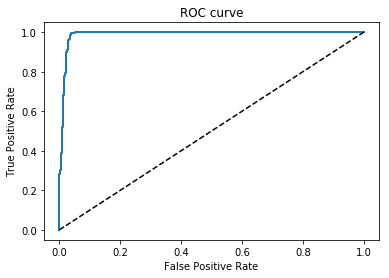

Area under the curve: 0.988905325443787


In [62]:
from sklearn.svm import SVC
svc = SVC()
svc_params = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel': ['rbf', 'poly']}
best = get_best_model_accuracy(svc, svc_params, X_train, y_train)
roc_curve_plot(svc, best, X_train, y_train)

### Gradient boosting

Best Accuracy: 0.9693251533742331
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 500}
Average Time to Fit (s): 0.123
Average Time to Score (s): 0.001
Precision: 0.9452054794520548
Recall: 0.9583333333333334
F1 score: 0.9517241379310345


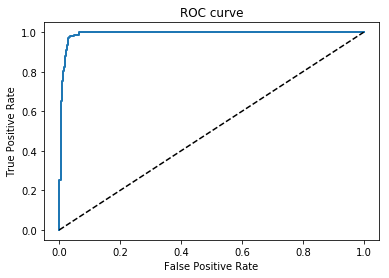

Area under the curve: 0.9908468934911242


In [63]:
from sklearn.ensemble import GradientBoostingClassifier
gbr = GradientBoostingClassifier()
gbr_params = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
              'n_estimators': [50, 100, 500]}
best = get_best_model_accuracy(gbr, gbr_params, X_train, y_train)
roc_curve_plot(gbr, best, X_train, y_train)

### Stochastic gradient boosting

Best Accuracy: 0.9754601226993865
Best Parameters: {'alpha': 0.001, 'penalty': 'l2'}
Average Time to Fit (s): 0.002
Average Time to Score (s): 0.001
Precision: 0.9452054794520548
Recall: 0.9583333333333334
F1 score: 0.9517241379310345


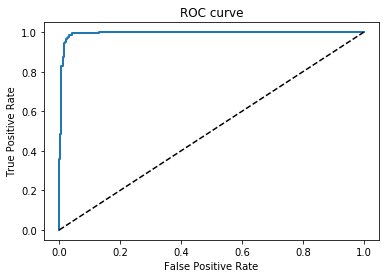

Area under the curve: 0.9936945266272189


In [64]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd_params = {'penalty': ['l1', 'l2'],
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
best = get_best_model_accuracy(sgd, sgd_params, X_train, y_train)
roc_curve_plot(sgd, best, X_train, y_train)

Looks like we have top 2 winners: random forest and support vector machine, in terms of time cost to fit the model as well as the accuracy score, f1 score, logistic regression is also a good choice since it can be trained really fast, especially if we have a large amount of data, we will use these three method to test our test set

In [65]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
rf = RandomForestClassifier(max_depth=9)
rf.fit(X_train, y_train)
print('Accuracy: {}'.format(rf.score(X_test, y_test)))
print('Precision: {}'.format(precision_score(y_test, rf.predict(X_test))))
print('Recall: {}'.format(recall_score(y_test, rf.predict(X_test))))
print('F1 score: {}'.format(f1_score(y_test, rf.predict(X_test))))

Accuracy: 0.9476190476190476
Precision: 0.9295774647887324
Recall: 0.9166666666666666
F1 score: 0.9230769230769231


In [66]:
svc = SVC(C=0.01, kernel='poly')
svc.fit(X_train, y_train)
print('Accuracy: {}'.format(svc.score(X_test, y_test)))
print('Precision: {}'.format(precision_score(y_test, svc.predict(X_test))))
print('Recall: {}'.format(recall_score(y_test, svc.predict(X_test))))
print('F1 score: {}'.format(f1_score(y_test, svc.predict(X_test))))

Accuracy: 0.9142857142857143
Precision: 0.9354838709677419
Recall: 0.8055555555555556
F1 score: 0.8656716417910448


In [68]:
lsvc = LinearSVC(C=1, penalty='l2')
lsvc.fit(X_train, y_train)
print('Accuracy: {}'.format(lsvc.score(X_test, y_test)))
print('Precision: {}'.format(precision_score(y_test, lsvc.predict(X_test))))
print('Recall: {}'.format(recall_score(y_test, lsvc.predict(X_test))))
print('F1 score: {}'.format(f1_score(y_test, lsvc.predict(X_test))))

Accuracy: 0.9476190476190476
Precision: 0.9552238805970149
Recall: 0.8888888888888888
F1 score: 0.9208633093525178


In [67]:
lgr = LogisticRegression(C=10, penalty='l1')
lgr.fit(X_train, y_train)
print('Accuracy: {}'.format(lgr.score(X_test, y_test)))
print('Precision: {}'.format(precision_score(y_test, lgr.predict(X_test))))
print('Recall: {}'.format(recall_score(y_test, lgr.predict(X_test))))
print('F1 score: {}'.format(f1_score(y_test, lgr.predict(X_test))))

Accuracy: 0.9619047619047619
Precision: 0.9324324324324325
Recall: 0.9583333333333334
F1 score: 0.9452054794520548
